# CNN Cancer Detection Kaggle Mini-Project

## Problem/Data

#### Citation: Kaggle - https://www.kaggle.com/competitions/histopathologic-cancer-detection/data
Dataset Description  
In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark.

## Running times
- This notebook was running on a PC with AMD Ryzen 9 12-core processor, 64 GB RAM and NVIDIA GeForce RTX 4080 SUPER (16 GB).
- Torch was using the NVIDIA GPUs because the CUDA (NVIDIA driver) was installed (on Windows 11).
- Some scripts were running several hours. On a PC wiht no GPU available it will run a very very long time.

## Notebook
- Import Libraries
- Set configuration data
- Check Torch version and CUDA availability (for GPU usage)

In [6]:
# Import Libraries
import os
import random
import copy
import math
import time
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as T
from torchvision import models

import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
class CFG:
    # Paths
    TRAIN_DIR = Path("train") 
    TRAIN_CSV = Path("train_labels.csv")
    SAMPLE_SUB_PATH = Path("sample_submission.csv")
    TEST_DIR = Path("test")   
    OUTPUT_SUB_PATH = Path("submission.csv")

    # Data / loader
    IMG_SIZE = 224   # 224x224 for ResNet
    BATCH_SIZE = 64  # e.g. 64
    NUM_WORKERS = 0  # can be raised if you have more CPU (e.g. 4) but could stuck in Windows 11

    # Training
    EPOCHS = 10      # Epochs for baseline model ResNet18                     
    WEIGHT_DECAY = 1e-4
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu" 
    USE_FP16 = True         

In [8]:
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("device:", torch.cuda.get_device_name(0))
    print("capability:", torch.cuda.get_device_capability(0))

torch: 2.5.1
cuda available: True
device: NVIDIA GeForce RTX 4080 SUPER
capability: (8, 9)


## Data Load

Data was downloaded from: https://www.kaggle.com/competitions/histopathologic-cancer-detection/data  
I created sub directories in the directory in which the notebook is running (see class CFG for details).  
You can choose an own directory structure and change class CFG accordingly.  
After download of the .zip file you can extract the files.
You will have test directory and a train directory with pictures in tif format and a train_labels.cv file and a sample_submission.csv file.  
The download and extraction will take a while (277,485 files / 7.76 GB).  

In [11]:
### Loading of the train data
df = pd.read_csv(CFG.TRAIN_CSV)

## Exploratory Data Analysis (EDA)
Inspect, Visualize and Clean the Data 

#### Number of pictures

In [14]:
print("Number of train images:", len(list(CFG.TRAIN_DIR.glob("*.tif"))))
print("Number of test  images:", len(list(CFG.TEST_DIR.glob("*.tif"))))

Number of train images: 220025
Number of test  images: 57458


#### Preview of a few pictures

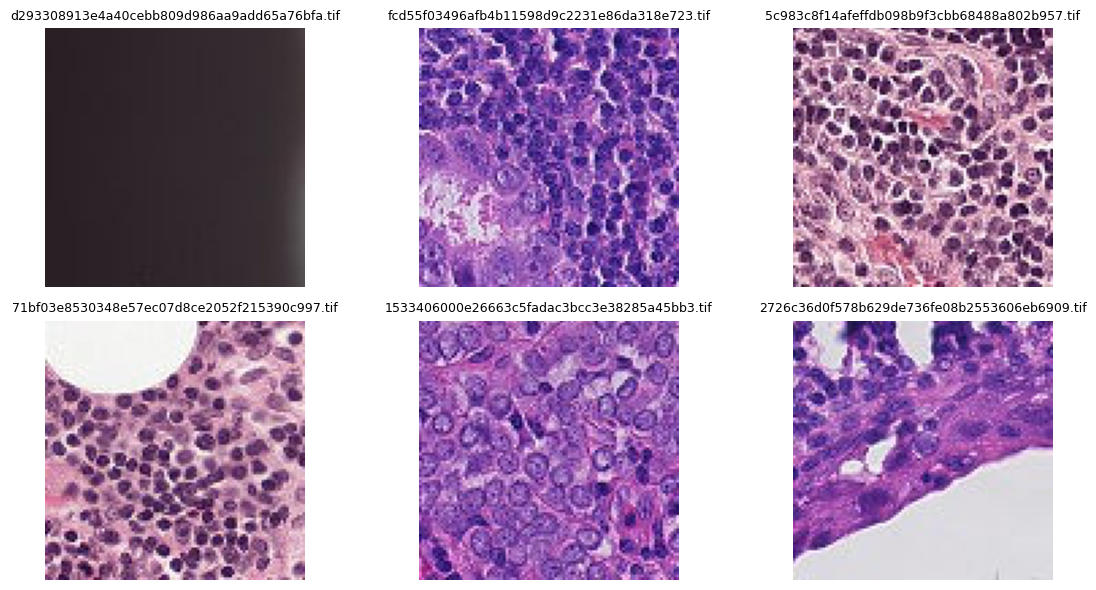

In [16]:
k = 6  # number of images to preview
sample_ids = df["id"].sample(k, random_state=42).tolist()
paths = [CFG.TRAIN_DIR / f"{i}.tif" for i in sample_ids]

plt.figure(figsize=(12, 6))
for i, p in enumerate(paths, 1):
    im = Image.open(p)
    plt.subplot(2, 3, i)
    if im.mode == "L":
        plt.imshow(im, cmap="gray")
    else:
        plt.imshow(im)
    plt.title(p.name, fontsize=9)
    plt.axis("off")
plt.tight_layout()
plt.show()

#### Inspect formats

In [18]:
formats = []
for path in (CFG.TRAIN_DIR).glob("*.tif"):
    with Image.open(path) as img:
        formats.append(img.format)
print("Unique formats found in train directory:", set(formats))
print(f"Total images checked: {len(formats)}")

formats = []
for path in (CFG.TEST_DIR).glob("*.tif"):
    with Image.open(path) as img:
        formats.append(img.format)
print("Unique formats found in test directory:", set(formats))
print(f"Total images checked: {len(formats)}")

Unique formats found in train directory: {'TIFF'}
Total images checked: 220025
Unique formats found in test directory: {'TIFF'}
Total images checked: 57458


#### Inspect resolution

In [20]:
sizes = []
for path in (CFG.TRAIN_DIR).glob("*.tif"):
    with Image.open(path) as img:
        sizes.append(img.size)  
print("Unique resolutions found in train directory:", set(sizes))
print(f"Total images checked: {len(sizes)}")

sizes = []
for path in (CFG.TEST_DIR).glob("*.tif"):
    with Image.open(path) as img:
        sizes.append(img.size)  
print("Unique resolutions found in test directory:", set(sizes))
print(f"Total images checked: {len(sizes)}")

Unique resolutions found in train directory: {(96, 96)}
Total images checked: 220025
Unique resolutions found in test directory: {(96, 96)}
Total images checked: 57458


#### Check labels

In [22]:
print("Head of labels:")
display(df.head())

Head of labels:


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


#### Data Cleaning

In [24]:
# Delete duplicates
df = df.drop_duplicates(subset=["id"]).reset_index(drop=True)

#### The dataset should consist only of files where the image file physically exists

In [26]:
df["filepath"] = df["id"].apply(lambda x: CFG.TRAIN_DIR / f"{x}.tif")
df = df[df["filepath"].apply(lambda p: p.exists())].reset_index(drop=True)
print("After filtering missing files:", df.shape)

After filtering missing files: (220025, 3)


### Plan
- Use models from ResNet which are pretrained on ImageNet.
- Transform the images to a resolution of 244x244 for ResNet models.
- Create a train dataset and a validation dataset from the available train data.
- Data preprocessing:
  - Data augmentation 
  - Normalization
- Hyperparameter Tuning:
  - Higher number of epochs
- Use Torch on CUDA for faster computation

## Train and Validate dataset split

We use stratify for the Train- Validate dataset split to preserve the class balance.

In [30]:
train_df, val_df = train_test_split(
    df,
    test_size=0.1,
    random_state=42,
    stratify=df["label"]   
)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print("train size:", len(train_df), "/ positives =", train_df['label'].sum())
print("validation size:", len(val_df), "/ positives =", val_df['label'].sum())

train size: 198022 / positives = 80205
validation size: 22003 / positives = 8912


We have roughly the same proportion of positives in boths sets (about 40%).  
Remark: Positives have label = 1.

## Model building and training

#### Image pre-processing and loading into Torch before training

In [34]:
### Image pre-processing 

# Mean and standard deviation used to normalize images for models pretrained on ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# Data augmentation and normalization
train_transforms = T.Compose([
    T.Resize((CFG.IMG_SIZE, CFG.IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(degrees=20),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

val_transforms = T.Compose([
    T.Resize((CFG.IMG_SIZE, CFG.IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# Custom dataset class
class HistoDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["filepath"]
        label = row["label"]

        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(label, dtype=torch.float32)
        return img, label

In [35]:
### Build dataset objects 
train_dataset = HistoDataset(train_df, train_transforms)
val_dataset   = HistoDataset(val_df,   val_transforms)

# Wrap datasets with DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CFG.BATCH_SIZE,
    shuffle=True,
    num_workers=CFG.NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CFG.BATCH_SIZE,
    shuffle=False,
    num_workers=CFG.NUM_WORKERS,
    pin_memory=True
)

print ("Number of batches:", "train:", len(train_loader), "/ validation:", len(val_loader))

Number of batches: train: 3095 / validation: 344


#### Model Building - Base Model - ResNet-18 
- ResNet-18 pretrained on ImageNet. It is lightweight, relatively fast to train and still deep enough.
- Defining a binary cross-entropy loss (BCEWithLogitsLoss).
- Setting up an Adam optimizer and a learning-rate scheduler (ReduceLROnPlateau).
- Initializing a mixed-precision gradient scaler for FP16 training on CUDA.
- 10 Epochs for the base model.
- Learning rate of 1e-3 (0.001).

#### Training

#### Define Functions

In [39]:
### Metrics function 

def compute_metrics(y_true, y_logits):
    """
    y_true: tensor/list of 0/1 labels, shape [N]
    y_logits: raw model outputs BEFORE sigmoid, shape [N] or [N,1]

    returns:
    auc, acc, cm, y_true_np, y_prob_np
    """
    # Move from GPU to CPU numpy
    y_true_t  = torch.as_tensor(y_true).float().cpu()
    y_logits_t = torch.as_tensor(y_logits).float().cpu()

    # Convert logits 
    y_prob = torch.sigmoid(y_logits_t)  
    y_prob_np = y_prob.numpy()

    # Binary predictions 
    y_pred_bin = (y_prob_np >= 0.5).astype(int)

    y_true_np = y_true_t.numpy()

    # AUC can fail if only one class is present
    try:
        auc = roc_auc_score(y_true_np, y_prob_np)
    except ValueError:
        auc = float("nan")

    acc = accuracy_score(y_true_np, y_pred_bin)
    cm  = confusion_matrix(y_true_np, y_pred_bin)

    return auc, acc, cm, y_true_np, y_prob_np

In [40]:
### Train function 
def train_one_epoch(model, dataloader, optimizer, criterion, scaler):
    model.train()
    device = CFG.DEVICE

    running_loss = 0.0
    all_targets = []
    all_logits  = []

    total_steps = len(dataloader)

    for step, (imgs, labels) in enumerate(dataloader, start=1):
        imgs   = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).view(-1, 1)  

        optimizer.zero_grad(set_to_none=True)

        # autocast 
        with torch.amp.autocast(
            device_type="cuda",
            enabled=(device == "cuda" and CFG.USE_FP16)
        ):
            logits = model(imgs)              
            loss = criterion(logits, labels)  

        # scaled backwards pass if FP16 enabled
        if device == "cuda" and CFG.USE_FP16:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        # bookkeeping
        running_loss += loss.item() * imgs.size(0)
        all_targets.append(labels.detach().cpu())
        all_logits.append(logits.detach().cpu())

        # progress print every 100 steps
        #if step % 100 == 0 or step == total_steps:
         #   print(f"[train] step {step}/{total_steps} loss={loss.item():.4f}")

    # concat everything
    all_targets = torch.cat(all_targets).view(-1)   
    all_logits  = torch.cat(all_logits).view(-1)    

    # epoch-level metrics
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_auc, epoch_acc, _cm, _, _ = compute_metrics(all_targets, all_logits)

    return epoch_loss, epoch_auc, epoch_acc

In [41]:
### Validate function 
@torch.no_grad()               #disable gradient tracking
def validate(model, dataloader, criterion):
    model.eval()
    device = CFG.DEVICE

    running_loss = 0.0
    all_targets = []
    all_logits  = []

    for imgs, labels in dataloader:
        imgs   = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).view(-1, 1)

        with torch.amp.autocast(
            device_type="cuda",
            enabled=(device == "cuda" and CFG.USE_FP16)
        ):
            logits = model(imgs)              
            loss = criterion(logits, labels) 

        running_loss += loss.item() * imgs.size(0)

        all_targets.append(labels.detach().cpu())
        all_logits.append(logits.detach().cpu())

    # concat 
    all_targets = torch.cat(all_targets).view(-1)
    all_logits  = torch.cat(all_logits).view(-1)

    # metrics
    val_loss = running_loss / len(dataloader.dataset)
    val_auc, val_acc, cm, y_true_np, y_prob_np = compute_metrics(all_targets, all_logits)

    return val_loss, val_auc, val_acc, cm, y_true_np, y_prob_np

In [42]:
### Prediction  
@torch.no_grad()
def predict_test(model, loader):
    model.eval()
    all_ids = []
    all_probs = []

    for imgs, ids in loader:
        imgs = imgs.to(CFG.DEVICE, non_blocking=True)
        with torch.amp.autocast(
            device_type="cuda",
            enabled=(CFG.DEVICE == "cuda" and CFG.USE_FP16)
        ):
            logits = model(imgs)
            probs = torch.sigmoid(logits).cpu().numpy().ravel()

        all_ids.extend(ids)
        all_probs.extend(probs.tolist())

    return np.array(all_ids), np.array(all_probs)

In [43]:
### Building test dataset 
class HistoTestDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.paths = sorted(list(Path(img_dir).glob("*.tif")))
        self.ids = [p.stem for p in self.paths]
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.ids[idx]

test_dataset = HistoTestDataset(CFG.TEST_DIR, val_transforms)

test_loader = DataLoader(
    test_dataset,
    batch_size=CFG.BATCH_SIZE,
    shuffle=False,
    num_workers=CFG.NUM_WORKERS,
    pin_memory=True
)

len(test_loader)

898

#### Train the model - ResNet-18 Baseline

In [45]:
### Model building - ResNet-18
def get_model():
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, 1)
    return model

model = get_model().to(CFG.DEVICE)
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=CFG.WEIGHT_DECAY
)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=1  
)

scaler = torch.amp.GradScaler(device="cuda", enabled=(CFG.DEVICE=="cuda" and CFG.USE_FP16))
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [46]:
### Train the model - ResNet-18 - 10 Epochs
### This is running several hours if GPUs are availabe for CUDA (e.g. NVIDIA RTX 4080)
### It will run very very long if no GPUs are available!

best_auc = -1.0
history = {"epoch": [], "train_loss": [], "train_auc": [], "train_acc": [],
           "val_loss": [], "val_auc": [], "val_acc": [], "lr": []}
best_weights = None

for epoch in range(1, CFG.EPOCHS+1):
    print(f"\nEpoch {epoch}/{CFG.EPOCHS} ")

    train_loss, train_auc, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, scaler
    )
    val_loss, val_auc, val_acc, cm, y_true, y_pred = validate(
        model, val_loader, criterion
    )
    scheduler.step(val_auc)
    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["train_auc"].append(train_auc)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_auc"].append(val_auc)
    history["val_acc"].append(val_acc)
    history["lr"].append(optimizer.param_groups[0]["lr"])

    print(f"train: loss {train_loss:.4f} | auc {train_auc:.4f} | acc {train_acc:.4f}")
    print(f"valid: loss {val_loss:.4f} | auc {val_auc:.4f} | acc {val_acc:.4f}")
   
    if val_auc > best_auc:
        best_auc = val_auc
        best_weights = {k: v.cpu().clone() for k,v in model.state_dict().items()}
        print(f"New best AUC {best_auc:.4f} -> saving weights in memory")

if best_weights is not None:
    model.load_state_dict(best_weights)
    print(f"\nLoaded best new model with AUC {best_auc:.4f}")
else:
    print("\nWarning: no best weights captured for new model.")


Epoch 1/10 
train: loss 0.2716 | auc 0.9506 | acc 0.8901
valid: loss 0.2863 | auc 0.9715 | acc 0.8957
New best AUC 0.9715 -> saving weights in memory

Epoch 2/10 
train: loss 0.2260 | auc 0.9652 | acc 0.9119
valid: loss 0.1992 | auc 0.9735 | acc 0.9228
New best AUC 0.9735 -> saving weights in memory

Epoch 3/10 
train: loss 0.2084 | auc 0.9702 | acc 0.9202
valid: loss 0.1773 | auc 0.9802 | acc 0.9316
New best AUC 0.9802 -> saving weights in memory

Epoch 4/10 
train: loss 0.1983 | auc 0.9727 | acc 0.9246
valid: loss 0.1655 | auc 0.9815 | acc 0.9379
New best AUC 0.9815 -> saving weights in memory

Epoch 5/10 
train: loss 0.1925 | auc 0.9743 | acc 0.9268
valid: loss 0.1798 | auc 0.9789 | acc 0.9312

Epoch 6/10 
train: loss 0.1887 | auc 0.9752 | acc 0.9285
valid: loss 0.1739 | auc 0.9808 | acc 0.9349

Epoch 7/10 
train: loss 0.1661 | auc 0.9804 | acc 0.9383
valid: loss 0.1344 | auc 0.9870 | acc 0.9523
New best AUC 0.9870 -> saving weights in memory

Epoch 8/10 
train: loss 0.1614 | auc 0

#### Save model to disk

In [48]:
# Save model to disk 
torch.save(model.state_dict(), "best_model_weights-18-10.pth")
print("Saved best model weights to best_model_weights-18-10.pth")

Saved best model weights to best_model_weights-18-10.pth


In [49]:
#### Example for model loading
# model = get_model().to(CFG.DEVICE)
# model.load_state_dict(torch.load("best_model_weights.pth", map_location=CFG.DEVICE))
# model.eval()

#### Prediction

In [51]:
### Prediction - Baseline model (ResNet-18) 
test_ids, test_probs = predict_test(model, test_loader)
sub_df = pd.DataFrame({"id": test_ids, "label": test_probs})
sub_df = sub_df.sort_values("id").reset_index(drop=True)

#### Show model performance

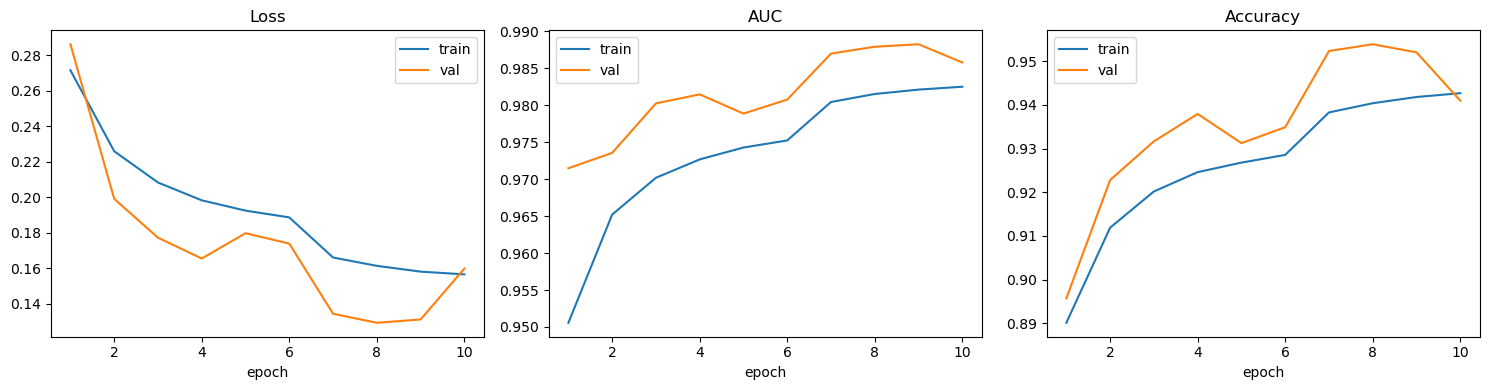

Final val AUC: 0.9882389056537946


In [53]:
### Show model performance - ResNet-18
fig, ax = plt.subplots(1,3, figsize=(15,4))

ax[0].plot(history["epoch"], history["train_loss"], label="train")
ax[0].plot(history["epoch"], history["val_loss"], label="val")
ax[0].set_title("Loss")
ax[0].set_xlabel("epoch")
ax[0].legend()

ax[1].plot(history["epoch"], history["train_auc"], label="train")
ax[1].plot(history["epoch"], history["val_auc"], label="val")
ax[1].set_title("AUC")
ax[1].set_xlabel("epoch")
ax[1].legend()

ax[2].plot(history["epoch"], history["train_acc"], label="train")
ax[2].plot(history["epoch"], history["val_acc"], label="val")
ax[2].set_title("Accuracy")
ax[2].set_xlabel("epoch")
ax[2].legend()

plt.tight_layout()
plt.show()

print("Final val AUC:", best_auc)

### Submission / Result

In [55]:
# Create submission file - ResNet-18
sub_df.to_csv(CFG.OUTPUT_SUB_PATH, index=False)
print(f"Saved submission CSV to {CFG.OUTPUT_SUB_PATH}")
print("Rows:", len(sub_df))

Saved submission CSV to submission.csv
Rows: 57458


#### Kaggle - ResNet-18 - Baseline  
Private Score: 0.9518  
Public Score: 0.9614

## Hyperparameter Tuning
- Using more epochs 

#### ResNet-18 model with 15 epochs

In [59]:
### Train the model - ResNet-18 - 15 Epochs
### This is running several hours if GPUs are availabe for CUDA (e.g. NVIDIA RTX 4080)
### It will run very very long if no GPUs are available!

CFG.EPOCHS=15
best_auc = -1.0
mehistory = {"epoch": [], "train_loss": [], "train_auc": [], "train_acc": [],
           "val_loss": [], "val_auc": [], "val_acc": [], "lr": []}
best_weights = None

for epoch in range(1, CFG.EPOCHS+1):
    print(f"\nEpoch {epoch}/{CFG.EPOCHS} ")

    train_loss, train_auc, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, scaler
    )
    val_loss, val_auc, val_acc, cm, y_true, y_pred = validate(
        model, val_loader, criterion
    )
    scheduler.step(val_auc)
    mehistory["epoch"].append(epoch)
    mehistory["train_loss"].append(train_loss)
    mehistory["train_auc"].append(train_auc)
    mehistory["train_acc"].append(train_acc)
    mehistory["val_loss"].append(val_loss)
    mehistory["val_auc"].append(val_auc)
    mehistory["val_acc"].append(val_acc)
    mehistory["lr"].append(optimizer.param_groups[0]["lr"])

    print(f"train: loss {train_loss:.4f} | auc {train_auc:.4f} | acc {train_acc:.4f}")
    print(f"valid: loss {val_loss:.4f} | auc {val_auc:.4f} | acc {val_acc:.4f}")
   
    if val_auc > best_auc:
        best_auc = val_auc
        best_weights = {k: v.cpu().clone() for k,v in model.state_dict().items()}
        print(f"New best AUC {best_auc:.4f} -> saving weights in memory")

if best_weights is not None:
    model.load_state_dict(best_weights)
    print(f"\nLoaded best new model (15 epochs) with AUC {best_auc:.4f}")
else:
    print("\nWarning: no best weights captured for new model with epochs = 15.")


Epoch 1/15 
train: loss 0.1554 | auc 0.9827 | acc 0.9432
valid: loss 0.1655 | auc 0.9858 | acc 0.9372
New best AUC 0.9858 -> saving weights in memory

Epoch 2/15 
train: loss 0.1404 | auc 0.9857 | acc 0.9496
valid: loss 0.1356 | auc 0.9886 | acc 0.9494
New best AUC 0.9886 -> saving weights in memory

Epoch 3/15 
train: loss 0.1382 | auc 0.9861 | acc 0.9503
valid: loss 0.1169 | auc 0.9902 | acc 0.9605
New best AUC 0.9902 -> saving weights in memory

Epoch 4/15 
train: loss 0.1360 | auc 0.9866 | acc 0.9510
valid: loss 0.1175 | auc 0.9903 | acc 0.9579
New best AUC 0.9903 -> saving weights in memory

Epoch 5/15 
train: loss 0.1344 | auc 0.9868 | acc 0.9519
valid: loss 0.1198 | auc 0.9900 | acc 0.9591

Epoch 6/15 
train: loss 0.1260 | auc 0.9883 | acc 0.9549
valid: loss 0.1065 | auc 0.9916 | acc 0.9634
New best AUC 0.9916 -> saving weights in memory

Epoch 7/15 
train: loss 0.1230 | auc 0.9888 | acc 0.9562
valid: loss 0.1042 | auc 0.9918 | acc 0.9644
New best AUC 0.9918 -> saving weights i

#### Save model to disk

In [61]:
# Save model to disk 
torch.save(model.state_dict(), "best_model_weights-18-15.pth")
print("Saved best model weights to best_model_weights-18-15.pth")

Saved best model weights to best_model_weights-18-15.pth


#### Prediction

In [63]:
### Prediction - Baseline model (ResNet-18) 
test_ids, test_probs = predict_test(model, test_loader)
sub_df = pd.DataFrame({"id": test_ids, "label": test_probs})
sub_df = sub_df.sort_values("id").reset_index(drop=True)

#### Show Model Performance

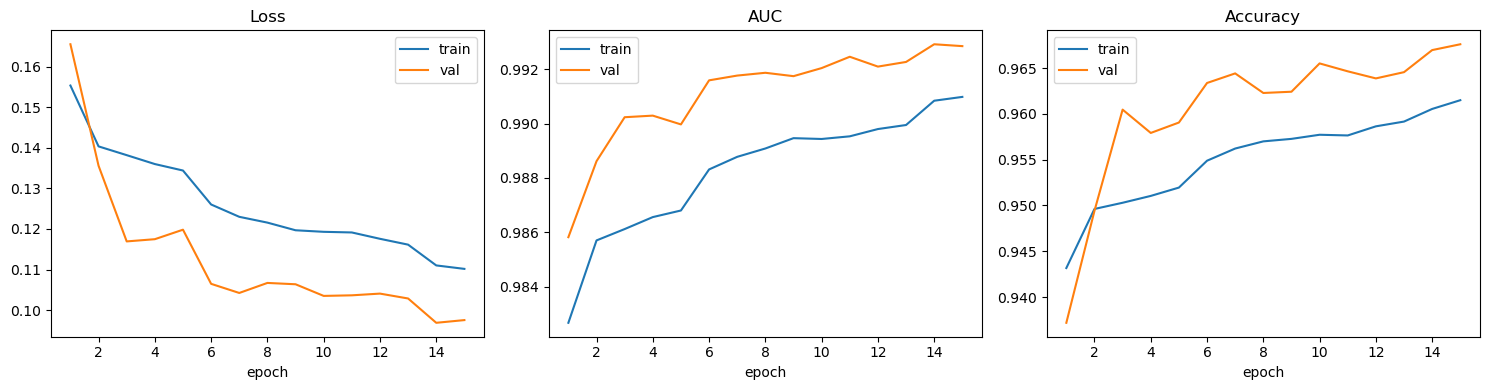

Final val AUC: 0.9929149668999782


In [65]:
### Show model performance - ResNet-18
fig, ax = plt.subplots(1,3, figsize=(15,4))

ax[0].plot(mehistory["epoch"], mehistory["train_loss"], label="train")
ax[0].plot(mehistory["epoch"], mehistory["val_loss"], label="val")
ax[0].set_title("Loss")
ax[0].set_xlabel("epoch")
ax[0].legend()

ax[1].plot(mehistory["epoch"], mehistory["train_auc"], label="train")
ax[1].plot(mehistory["epoch"], mehistory["val_auc"], label="val")
ax[1].set_title("AUC")
ax[1].set_xlabel("epoch")
ax[1].legend()

ax[2].plot(mehistory["epoch"], mehistory["train_acc"], label="train")
ax[2].plot(mehistory["epoch"], mehistory["val_acc"], label="val")
ax[2].set_title("Accuracy")
ax[2].set_xlabel("epoch")
ax[2].legend()

plt.tight_layout()
plt.show()

print("Final val AUC:", best_auc)

#### Submission / Result ResNet-18 with 15 epochs

In [67]:
# Create submission file
sub_df.to_csv(CFG.OUTPUT_SUB_PATH, index=False)
print(f"Saved submission CSV to {CFG.OUTPUT_SUB_PATH}")
print("Rows:", len(sub_df))

Saved submission CSV to submission.csv
Rows: 57458


#### Kaggle - ResNet-18 - 15 epochs
Private Score: 0.9670  
Public Score: 0.9595

## Run different models

#### Model Building - New Model - ResNet-50
- ResNet-50 pretrained on ImageNet. This model is deeper and learns richer features.
- Defining a binary cross-entropy loss (BCEWithLogitsLoss).
- Setting up an Adam optimizer and a learning-rate scheduler (ReduceLROnPlateau).
- Initializing a mixed-precision gradient scaler for FP16 training on CUDA.
- Higher number of epochs (15) for the bigger model.
- Learning rate of 3e-4 (0.0003) for the bigger model.

In [71]:
### Model building ResNet-50 (new model)
def get_nmodel():
    m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    in_feats = m.fc.in_features
    m.fc = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(in_feats, 1)
    )
    return m

nmodel = get_nmodel().to(CFG.DEVICE)
criterion = nn.BCEWithLogitsLoss()

# for ResNet-50 CFG.LR = 3e-4          
optimizer = torch.optim.Adam(nmodel.parameters(), lr=3e-4, weight_decay=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=CFG.EPOCHS)

scaler = torch.amp.GradScaler(device="cuda", enabled=(CFG.DEVICE=="cuda" and CFG.USE_FP16))
print(nmodel)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Training new model - ResNet-50

In [73]:
### Train the new model - ResNet-50
### This is running several hours if GPUs are availabe for CUDA (e.g. NVIDIA RTX 4080)
### It will run very very long if no GPUs are available!

CFG.EPOCHS=15
best_auc = -1.0
nhistory = {"epoch": [], "train_loss": [], "train_auc": [], "train_acc": [],
           "val_loss": [], "val_auc": [], "val_acc": [], "lr": []}
best_weights = None

for epoch in range(1, CFG.EPOCHS+1):
    print(f"\n Epoch {epoch}/{CFG.EPOCHS} ")

    train_loss, train_auc, train_acc = train_one_epoch(
        nmodel, train_loader, optimizer, criterion, scaler
    )
    val_loss, val_auc, val_acc, cm, y_true, y_pred = validate(
        nmodel, val_loader, criterion
    )

    scheduler = CosineAnnealingLR(optimizer, T_max=CFG.EPOCHS)
    nhistory["epoch"].append(epoch)
    nhistory["train_loss"].append(train_loss)
    nhistory["train_auc"].append(train_auc)
    nhistory["train_acc"].append(train_acc)
    nhistory["val_loss"].append(val_loss)
    nhistory["val_auc"].append(val_auc)
    nhistory["val_acc"].append(val_acc)
    nhistory["lr"].append(optimizer.param_groups[0]["lr"])

    print(f"train: loss {train_loss:.4f} | auc {train_auc:.4f} | acc {train_acc:.4f}")
    print(f"valid: loss {val_loss:.4f} | auc {val_auc:.4f} | acc {val_acc:.4f}")
    
    if val_auc > best_auc:
        best_auc = val_auc
        best_weights = copy.deepcopy(nmodel.state_dict())   
        print(f"New best AUC {best_auc:.4f} -> saving weights in memory")

if best_weights is not None:
    nmodel.load_state_dict(best_weights)
    print(f"\nLoaded best new model with AUC {best_auc:.4f}")
else:
    print("\nWarning: no best weights captured for new model.")


 Epoch 1/15 
train: loss 0.2175 | auc 0.9681 | acc 0.9158
valid: loss 0.1440 | auc 0.9864 | acc 0.9485
New best AUC 0.9864 -> saving weights in memory

 Epoch 2/15 
train: loss 0.1748 | auc 0.9789 | acc 0.9344
valid: loss 0.1418 | auc 0.9854 | acc 0.9496

 Epoch 3/15 
train: loss 0.1608 | auc 0.9819 | acc 0.9402
valid: loss 0.1336 | auc 0.9890 | acc 0.9548
New best AUC 0.9890 -> saving weights in memory

 Epoch 4/15 
train: loss 0.1487 | auc 0.9843 | acc 0.9457
valid: loss 0.1187 | auc 0.9903 | acc 0.9579
New best AUC 0.9903 -> saving weights in memory

 Epoch 5/15 
train: loss 0.1414 | auc 0.9858 | acc 0.9489
valid: loss 0.1145 | auc 0.9907 | acc 0.9600
New best AUC 0.9907 -> saving weights in memory

 Epoch 6/15 
train: loss 0.1355 | auc 0.9868 | acc 0.9512
valid: loss 0.1096 | auc 0.9908 | acc 0.9625
New best AUC 0.9908 -> saving weights in memory

 Epoch 7/15 
train: loss 0.1295 | auc 0.9879 | acc 0.9532
valid: loss 0.1301 | auc 0.9905 | acc 0.9552

 Epoch 8/15 
train: loss 0.1246

#### Save model to disk

In [75]:
# save best weights
torch.save(nmodel.state_dict(), "best_new_model_weights-ResNet-50.pth")
print("Saved best_new_model_weights-ResNet-50.pth")

Saved best_new_model_weights-ResNet-50.pth


#### Prediction

In [77]:
### New model (ResNet-50) prediction
test_ids, test_probs = predict_test(nmodel, test_loader)
sub_df = pd.DataFrame({"id": test_ids, "label": test_probs})
sub_df = sub_df.sort_values("id").reset_index(drop=True)

#### Show model performance

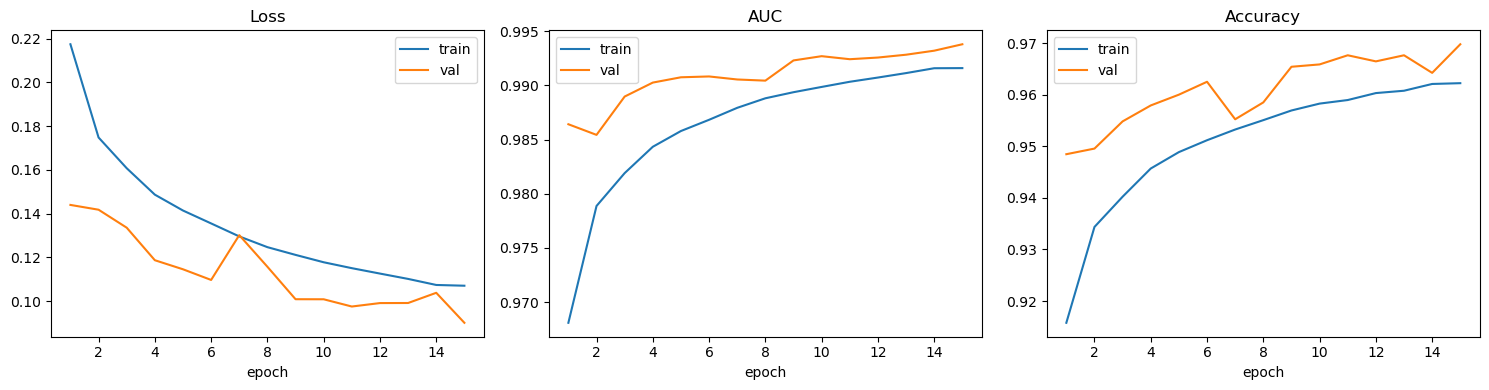

Final val AUC (new model): 0.9937924430245018


In [79]:
### Show model performance - ResNet-50
fig, ax = plt.subplots(1,3, figsize=(15,4))

ax[0].plot(nhistory["epoch"], nhistory["train_loss"], label="train")
ax[0].plot(nhistory["epoch"], nhistory["val_loss"], label="val")
ax[0].set_title("Loss")
ax[0].set_xlabel("epoch")
ax[0].legend()

ax[1].plot(nhistory["epoch"], nhistory["train_auc"], label="train")
ax[1].plot(nhistory["epoch"], nhistory["val_auc"], label="val")
ax[1].set_title("AUC")
ax[1].set_xlabel("epoch")
ax[1].legend()

ax[2].plot(nhistory["epoch"], nhistory["train_acc"], label="train")
ax[2].plot(nhistory["epoch"], nhistory["val_acc"], label="val")
ax[2].set_title("Accuracy")
ax[2].set_xlabel("epoch")
ax[2].legend()

plt.tight_layout()
plt.show()

print("Final val AUC (new model):", best_auc)

### Submission / Result new model

In [81]:
# Create submission file
sub_df.to_csv(CFG.OUTPUT_SUB_PATH, index=False)
print(f"Saved submission CSV to {CFG.OUTPUT_SUB_PATH}")
print("Rows:", len(sub_df))

Saved submission CSV to submission.csv
Rows: 57458


#### Kaggle - ResNet-50
Private Score: 0.9654  
Public Score: 0.9609

## Model Comparison
- The model with the best performance on Kaggle is: ResNet-18 with 15 epochs (Hyperparameter Tuning).
- Our dataset (about 220 K small 96×96 px images) is relatively simple and uniform.
- ResNet-50 has far more parameters (about 25 M) than ResNet-18 (about 11 M).
- On smaller or less diverse data, a large network can overfit subtle noise, while a smaller one generalizes better.
- Result: ResNet-18’s simpler feature hierarchy matches our dataset’s complexity better.

## Conclusions / Discussion

- ResNet-50 can achieve higher raw training AUC but doesn’t always translate to a better test results — especially with smaller, cleaner image datasets.
- The best private score is achieved by the ResNet-18 model with 15 epochs.
- Further Hyperparameter Tuning could be done with different leraning rates.
- Further Hyperparameter Tuning could be done with different batch sizes.  

### Kaggle:
ResNet-18 Baseline (10 epochs):  
Private Score: 0.9518  
Public Score: 0.9614

ResNet-50:  
Private Score: 0.9654  
Public Score: 0.9609

ResNet-18 - 15 epochs  
Private Score: 0.9670  
Public Score: 0.9595

## Citation
- Kaggle competition: Histopathologic Cancer Detection - https://www.kaggle.com/c/histopathologic-cancer-detection/overview

## AI Acknowledgement
ChatGPT-5 (OpenAI, 2025) was used to assist in proofreading and improving the grammatical accuracy of the Markdown content. No substantive changes to the original ideas or analysis were made by the model.